In [1]:
from environment import Environment
from models.baseline import BaselineModel
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('data/train_preprocessed.csv')
test_data = pd.read_csv('data/validate_preprocessed.csv')

In [3]:
def print_func(battery, prices, actions, rewards):
    '''for i in range(100):
        print('t=%d, battery=%.2f, price=%.2f, action=%d, rewards=%.2f'%(i, battery[i], prices[i], actions[i], rewards[i]))
    '''
    
    print('total reward = ', sum(rewards))
    
    '''for i in range(len(battery)):
        if actions[i] != 25:
            hour = i%24
            print('t=%d, hour=%d battery=%.2f, price=%.2f, action=%d, rewards=%.2f'%(i, hour, battery[i], prices[i], actions[i], rewards[i]))
    '''
    
    return

def plot_func(battery, prices, actions, rewards):
    x = range(len(battery))
    
    fig, axis = plt.subplots(2,3, figsize=(12,8))
    for ax, val, name in zip(axis.flat, 
                             [battery, prices, actions, rewards, np.cumsum(np.array(rewards))],
                               ['Battery', 'Prices', 'Actions', 'Rewards', 'Cumulative rewards']):
        ax.scatter(x, val, s=1)
        ax.set_title(name)
    plt.show()

In [4]:
def learn(env, model, t_max):
    rewards, battery, revenues, actions, prices = [], [], [], [], []
    i=0
    obs, reward = env.reset()
    
    while i<t_max:
        action = model.predict(data, obs)
        battery.append(obs['battery'])
        prices.append(obs['price'])
        
        obs, reward = env.step(action)
        
        actions.append(action)
        rewards.append(reward)
        i+=1
        
    #print_func(battery, prices, actions, rewards)
    plot_func(battery, prices, actions, rewards)
    
    return

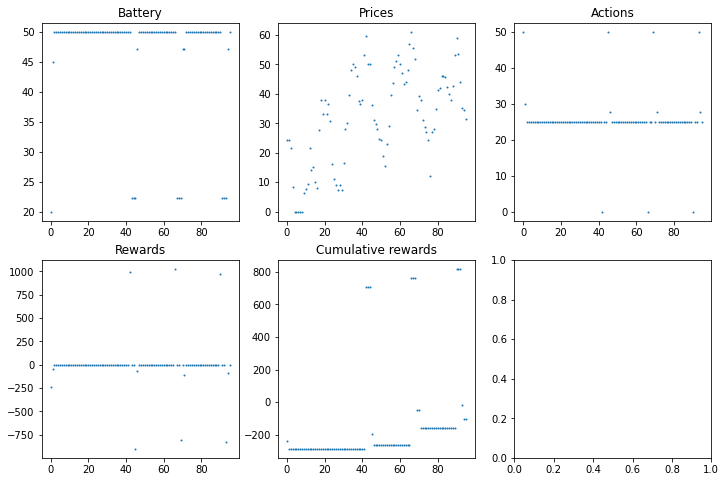

In [5]:
env = Environment(data)
model = BaselineModel(test_data)
t_max = 24*4

learn(env, model, t_max)